# Pore Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.svm import SVC

# Import data

In [2]:
unidentified_pore_data = pd.read_csv('data/microscopy-data.csv')
dunk_data = pd.read_csv('data/dunking-data.csv')
unidentified_pore_data

,gamma,phi,eta,L,t,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07
...,...,...,...,...,...,...
495,0.077699,1.481847,0.000989,0.006078,21.967531,4.751893e-07
496,0.067776,1.488293,0.001011,0.006595,18.163634,8.798032e-07
497,0.074166,1.554817,0.000997,0.003041,18.000978,8.652230e-07
498,0.081415,1.439910,0.001011,0.009119,19.136713,8.128785e-07


In [24]:
# Merge dataframes to identify biscuits in pore data

pore_data = pd.merge(unidentified_pore_data, dunk_data, on = ['gamma', 'phi', 'eta', 'L', 't'], how = 'left')
pore_data

,gamma,phi,eta,L,t,r,biscuit
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07,Digestive
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07,Rich Tea
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07,Hobnob
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07,Digestive
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07,Digestive
...,...,...,...,...,...,...,...
495,0.077699,1.481847,0.000989,0.006078,21.967531,4.751893e-07,Hobnob
496,0.067776,1.488293,0.001011,0.006595,18.163634,8.798032e-07,Digestive
497,0.074166,1.554817,0.000997,0.003041,18.000978,8.652230e-07,Digestive
498,0.081415,1.439910,0.001011,0.009119,19.136713,8.128785e-07,Digestive


In [4]:
# See how many of each biscuit is in dataframe

value_counts = pore_data['biscuit'].value_counts()
value_counts

biscuit
Rich Tea     169
Digestive    168
Hobnob       163
Name: count, dtype: int64

## Difference between biscuit pore radii

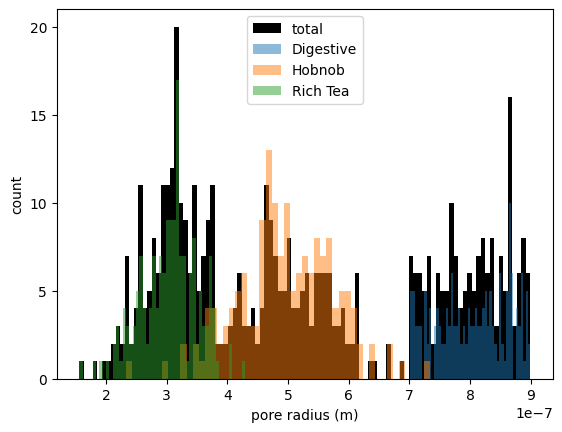

In [5]:
fig, ax = plt.subplots()

ax.hist(pore_data['r'], bins = 100, label = 'total', color = 'black')

for biscuit in np.unique(pore_data['biscuit']):
    ax.hist(pore_data[pore_data['biscuit'] == biscuit]['r'], bins = 50, label = biscuit, alpha = 0.5)

ax.set_xlabel('pore radius (m)')
ax.set_ylabel('count')
ax.set_yticks(np.linspace(0,20,5))
plt.legend()

plt.show()

In [6]:
# Get means and variances in pore radius for each biscuit

means = []
variances = []

for biscuit in np.unique(pore_data['biscuit']):
    variance = np.var(pore_data[pore_data['biscuit'] == biscuit]['r'])
    mean = np.mean(pore_data[pore_data['biscuit'] == biscuit]['r'])
    means.append(mean)
    variances.append(variance)

means_vars = pd.DataFrame(data = {'biscuit':np.unique(pore_data['biscuit']),
                                   'mean': means,
                                  'variance':variances})
means_vars

,biscuit,mean,variance
0,Digestive,8.034292e-07,3.364683e-15
1,Hobnob,4.963689e-07,6.404967e-15
2,Rich Tea,3.038971e-07,2.211468e-15


# See if radius data affects pca weighting

In [7]:
scaled_data = scale(pore_data.drop(['biscuit'], axis = 1))

In [8]:
pca_6 = PCA(n_components = 6)
pca_6.fit(scaled_data)

transformed_6 = pca_6.fit_transform(scaled_data)

In [9]:
# Define new PCA to get two largest components

pca_2 = PCA(n_components = 2)
transformed_2 = pca_2.fit_transform(scaled_data)

# Create Loading Matrix to see breakdown of two largest principal components

loading_matrix = pd.DataFrame(transformed_6[-2:].T* np.sqrt(pca_2.explained_variance_), 
                              columns=['PC1', 'PC2'], index = pore_data.columns[:6])
loading_matrix

,PC1,PC2
gamma,1.625283,-1.645182
phi,0.647797,1.122193
eta,-0.374457,-1.644515
L,-1.189069,-0.540379
t,1.976166,0.473983
r,-0.224136,-0.137189


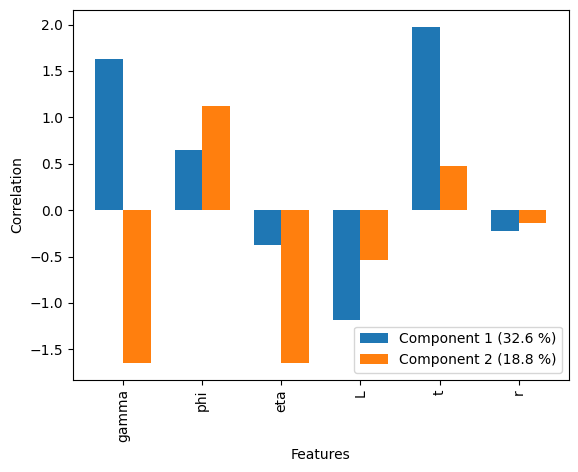

In [10]:
# Plot breakdowns of two largest principal components

ind = np.arange(len(loading_matrix.index))
width = 0.35

fig, ax = plt.subplots()
ax.bar(ind, loading_matrix['PC1'], width, 
       label='Component 1 ({:.1f} %)'.format(pca_6.explained_variance_ratio_[0] * 100))
ax.bar(ind + width, loading_matrix['PC2'], width, 
       label='Component 2 ({:.1f} %)'.format(pca_6.explained_variance_ratio_[1] * 100))
ax.set_xlabel('Features')
ax.set_ylabel('Correlation')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(loading_matrix.index)
ax.tick_params(axis='x', rotation=90)
ax.legend()
plt.show()

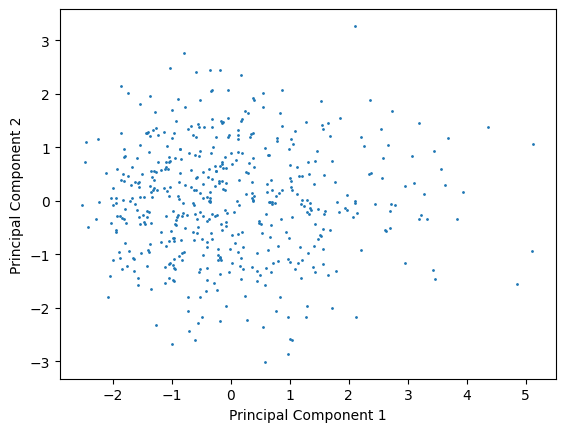

In [18]:
# Check for clustering in first two principal components

fig, ax = plt.subplots()

plt.scatter(transformed_2[:,0], transformed_2[:,1], s = 1)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

plt.show()

# Testing Random Forest Regressor

In [12]:
# Split test and train data

X = scale(pore_data.drop(['biscuit','r'], axis = 1))
y = pore_data['r']

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

((375, 5), (125, 5))

In [13]:
# Train rf regressor

rf_regressor = RandomForestRegressor(random_state = 0)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

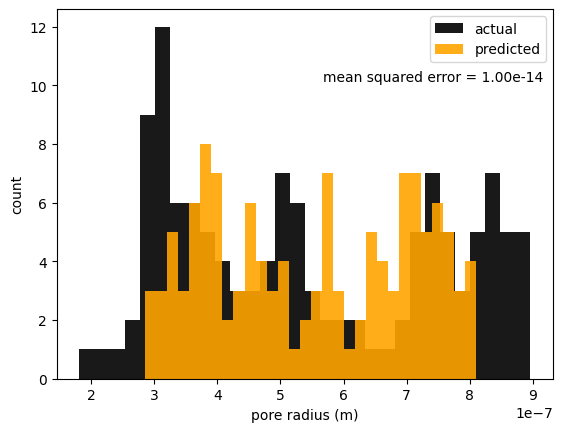

In [14]:
# Try on test data and plot

y_pred = rf_regressor.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred)

fig, ax = plt.subplots()

ax.hist(y_test, bins = 30, label = 'actual', alpha = 0.9, color = 'black')
ax.hist(y_pred, bins = 30, label = 'predicted', alpha = 0.9, color = 'orange')

ax.set_xlabel('pore radius (m)')
ax.set_ylabel('count')
plt.legend()
fig.text(0.54,0.73,s = f'mean squared error = {"{:.2e}".format(mse_rf)}')

plt.show()

# Testing Washburn equation predictions

In [31]:
# Define washburn predictor and use on test data

def washburn_radius_predictor(df):
    washburn_radii = []  
    for index, row in df.iterrows():
            washburn_radius = (2*row['eta']*(row['L'])**2)/(row['gamma']*row['t']*np.cos(row['phi']))
            washburn_radii.append(washburn_radius)
    return washburn_radii

wb_pred = washburn_radius_predictor(pore_data.loc[y_test.index.tolist()])

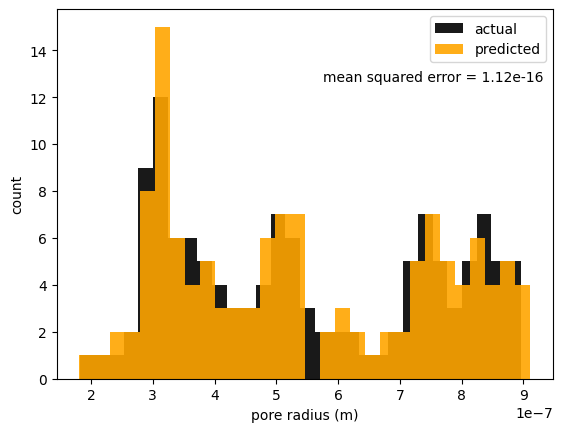

In [32]:
# Plot washburn predicted data

mse_wb = mean_squared_error(y_test, wb_pred)

fig, ax = plt.subplots()

ax.hist(y_test, bins = 30, label = 'actual', alpha = 0.9, color = 'black')
ax.hist(wb_pred, bins = 30, label = 'predicted', alpha = 0.9, color = 'orange')

ax.set_xlabel('pore radius (m)')
ax.set_ylabel('count')
plt.legend()
fig.text(0.54,0.73,s = f'mean squared error = {"{:.2e}".format(mse_wb)}')

plt.show()

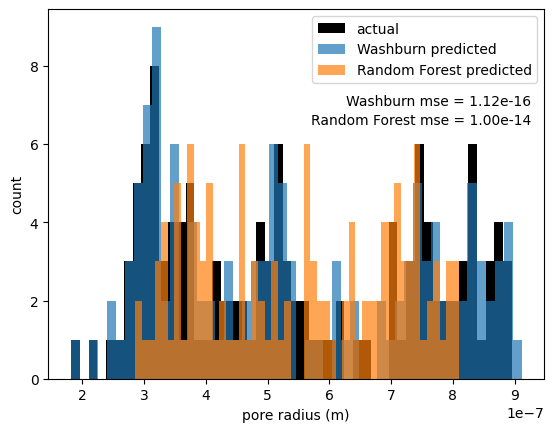

In [38]:
# Plot both

fig, ax = plt.subplots()

ax.hist(y_test, bins = 50, label = 'actual', color = 'black')
ax.hist(wb_pred, bins = 50, label = 'Washburn predicted', alpha = 0.7)
ax.hist(y_pred, bins = 50, label = 'Random Forest predicted', alpha = 0.7)

ax.set_xlabel('pore radius (m)')
ax.set_ylabel('count')
plt.legend()
fig.text(0.59,0.68,s = f'Washburn mse = {"{:.2e}".format(mse_wb)}')
fig.text(0.535,0.64,s = f'Random Forest mse = {"{:.2e}".format(mse_rf)}')

plt.show()